## Dokumen Kerangka Kerja: Analisis Retensi Pelanggan (Customer Churn)

**1. Latar Belakang Perusahaan**
- Dalam industri layanan berbasis langganan (seperti Telekomunikasi atau SaaS), pertumbuhan perusahaan sangat bergantung pada stabilitas basis pelanggan. Saat ini, biaya untuk mengakuisisi pelanggan baru (Customer Acquisition Cost) diperkirakan 5 hingga 25 kali lebih mahal daripada mempertahankan pelanggan yang sudah ada. Oleh karena itu, meminimalkan tingkat atrisi (churn) menjadi prioritas strategis untuk menjaga profitabilitas dan keberlanjutan bisnis.

**2. Pernyataan Masalah (Problem Statement)**
- Perusahaan mengamati adanya fluktuasi pada angka pelanggan keluar (churn) yang berpotensi menggerus pendapatan tahunan. Tanpa pemahaman mendalam mengenai alasan di balik berhentinya pelanggan, perusahaan berisiko melakukan strategi pemasaran yang tidak tepat sasaran dan membuang anggaran retensi pada segmen yang salah.

**3. Masalah Bisnis (Business Questions)**
**Analisis ini bertujuan untuk menjawab beberapa pertanyaan kunci melalui data:**
- Analisis Deskriptif: Berapa profil persentase churn saat ini dan bagaimana trennya berdasarkan durasi kontrak pelanggan?
- Analisis Diagnostik: Faktor layanan atau skema harga apa yang memiliki korelasi paling kuat terhadap keputusan pelanggan untuk berhenti?
- Analisis Prediktif (Opsional): Apakah kita dapat mengidentifikasi pelanggan yang berisiko tinggi (at-risk) sebelum mereka benar-benar melakukan terminasi?

**4. Tujuan Eksperimen (Objectives)**
- Segmentasi Risiko: Mengelompokkan pelanggan berdasarkan perilaku penggunaan dan profil demografis untuk menemukan pola churn.
- Rekomendasi Strategis: Menghasilkan rekomendasi kebijakan berbasis data (misalnya: penyesuaian harga atau peningkatan layanan pada segmen tertentu) untuk menurunkan angka churn sebesar 5-10%.

**5. Metodologi Teknis**
**Eksperimen ini akan diimplementasikan menggunakan arsitektur analisis modern:**
- Data Wrangling & Agregasi: Menggunakan SQL via DuckDB untuk pemrosesan data bervolume besar secara efisien langsung dari file lokal (.csv/.parquet).
- Eksplorasi Statistik: Menggunakan Python (Pandas) untuk manipulasi data tingkat lanjut.
- Visualisasi Data: Menggunakan Seaborn atau Plotly untuk menyajikan temuan dalam bentuk grafik yang mudah dipahami oleh pemangku kepentingan (stakeholders).


In [19]:
import duckdb
import pandas as pd


con = duckdb.connect()

df_check = con.sql("SELECT * FROM 'WA_Fn-UseC_-Telco-Customer-Churn.csv' LIMIT 5").df()
display(df_check)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,No phone service,DSL,No,...,No,No,No,No,Month-to-month,True,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,No,DSL,Yes,...,Yes,No,No,No,One year,False,Mailed check,56.95,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,No,DSL,Yes,...,No,No,No,No,Month-to-month,True,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,0,False,False,45,False,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,False,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,No,Fiber optic,No,...,No,No,No,No,Month-to-month,True,Electronic check,70.70,151.65,True


In [28]:
# Cek baris yang TotalCharges-nya bukan angka
non_numeric_check = con.sql("""
    SELECT 
        TotalCharges, 
        COUNT(*) as jumlah_temuan
    FROM 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
    WHERE TRY_CAST(TotalCharges AS DOUBLE) IS NULL
    GROUP BY TotalCharges
""").df()

display(non_numeric_check)


,TotalCharges,jumlah_temuan
0,,11


In [29]:
con.sql("""
    SELECT 
        COUNT(*) as total_baris,
        COUNT(CASE WHEN TotalCharges = ' ' THEN 1 END) as jumlah_spasi_kosong,
        COUNT(CASE WHEN TotalCharges IS NULL THEN 1 END) as jumlah_null_asli
    FROM 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
""").show()


┌─────────────┬─────────────────────┬──────────────────┐
│ total_baris │ jumlah_spasi_kosong │ jumlah_null_asli │
│    int64    │        int64        │      int64       │
├─────────────┼─────────────────────┼──────────────────┤
│        7043 │                  11 │                0 │
└─────────────┴─────────────────────┴──────────────────┘



In [32]:
df_sample = con.sql("SELECT * FROM 'WA_Fn-UseC_-Telco-Customer-Churn.csv' LIMIT 1").df()

# Loop untuk cek nilai unik di setiap kolom object/string
for col in df_sample.columns:
    print(f"--- Unique Values di Kolom: {col} ---")
    con.sql(f"SELECT DISTINCT {col} FROM 'WA_Fn-UseC_-Telco-Customer-Churn.csv' LIMIT 5").show()


--- Unique Values di Kolom: customerID ---
┌────────────┐
│ customerID │
│  varchar   │
├────────────┤
│ 7590-VHVEG │
│ 9763-GRSKD │
│ 8091-TTVAX │
│ 6865-JZNKO │
│ 6467-CHFZW │
└────────────┘

--- Unique Values di Kolom: gender ---
┌─────────┐
│ gender  │
│ varchar │
├─────────┤
│ Female  │
│ Male    │
└─────────┘

--- Unique Values di Kolom: SeniorCitizen ---
┌───────────────┐
│ SeniorCitizen │
│     int64     │
├───────────────┤
│             0 │
│             1 │
└───────────────┘

--- Unique Values di Kolom: Partner ---
┌─────────┐
│ Partner │
│ boolean │
├─────────┤
│ false   │
│ true    │
└─────────┘

--- Unique Values di Kolom: Dependents ---
┌────────────┐
│ Dependents │
│  boolean   │
├────────────┤
│ false      │
│ true       │
└────────────┘

--- Unique Values di Kolom: tenure ---
┌────────┐
│ tenure │
│ int64  │
├────────┤
│     22 │
│     16 │
│     52 │
│     11 │
│     15 │
└────────┘

--- Unique Values di Kolom: PhoneService ---
┌──────────────┐
│ PhoneService │
│   bo

In [36]:
# Tahap Investigasi (Manual SQL):
# Cek nilai unik untuk melihat anomali (spasi, typo, nilai aneh)
con.sql("SELECT DISTINCT TotalCharges FROM 'WA_Fn-UseC_-Telco-Customer-Churn.csv' LIMIT 20").df()


,TotalCharges
0,7895.15
1,20.2
2,1216.6
3,5714.25
4,927.65
5,2868.15
6,3423.5
7,2151.6
8,1215.65
9,3260.1


In [ ]:
SELECT DISTINCT TotalCharges 
FROM 'data.csv' 
ORDER BY LENGTH(TotalCharges) ASC


SELECT TotalCharges, COUNT(*) as jumlah
FROM 'data.csv'
GROUP BY TotalCharges
ORDER BY jumlah ASC  -- Nilai yang cuma muncul 1-2 kali biasanya typo/anomali


In [38]:
# tahap validasi
# Hitung berapa banyak baris yang isinya cuma spasi
con.sql("SELECT COUNT(*) FROM 'WA_Fn-UseC_-Telco-Customer-Churn.csv' WHERE TotalCharges = ' '").df()


,count_star()
0,11


# catatan lain kali distinct satu-satu baru buat dataframe yang bersih biar gak bengong

**penjelasan query**
1. Membuat koneksi DuckDB
2. Menggunakan SQL untuk melihat 5 baris pertama dan struktur data - Ganti nama file jika letaknya di subfolder, misal: 'data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

---

In [ ]:
# Tahap Fix & Build (Materialisasi)

con.execute("""
    CREATE OR REPLACE TABLE churn_clean AS 
    SELECT 
        *,
        CAST(NULLIF(TotalCharges, ' ') AS DOUBLE) as TotalCharges_Fixed
    FROM 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
""")

print("Data Cleaning Selesai: Kolom TotalCharges telah diperbaiki.")


Data Cleaning Selesai: Kolom TotalCharges telah diperbaiki.


**Penjelasana Query**
- Query untuk membersihkan data:
1. Mengubah string kosong di TotalCharges menjadi NULL
2. Mengonversi TotalCharges menjadi DOUBLE
3. Membuat tabel temporary yang bersih untuk analisis


---

**Churn rate analyze**

In [21]:
# Analisis Churn Rate menggunakan SQL
churn_summary = con.sql("""
    SELECT 
        Churn, 
        COUNT(*) as Total_Pelanggan,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM churn_clean), 2) as Persentase
    FROM churn_clean
    GROUP BY Churn
""").df()

display(churn_summary)


,Churn,Total_Pelanggan,Persentase
0,False,5174,73.46
1,True,1869,26.54


"Berdasarkan profil data awal, perusahaan kehilangan lebih dari seperempat basis pelanggannya. Ini mengonfirmasi bahwa masalah churn berada pada tingkat kritikal yang memerlukan intervensi strategi retensi segera."

---

**looking for the smoking Gun analyze(penyebab utama)**

In [22]:
# Analisis Churn berdasarkan tipe kontrak
contract_analysis = con.sql("""
    SELECT 
        Contract,
        COUNT(*) as Total_Customer,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) as Churn_Count,
        ROUND(SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as Churn_Rate
    FROM churn_clean
    GROUP BY Contract
    ORDER BY Churn_Rate DESC
""").df()

display(contract_analysis)


,Contract,Total_Customer,Churn_Count,Churn_Rate
0,Month-to-month,3875,1655.0,42.71
1,One year,1473,166.0,11.27
2,Two year,1695,48.0,2.83


**pelanggan dengan tipe kontrak bulanan cenderung mudah pergi**

---

**analisis pemicu churn**
- Apakah Harga Memicu Churn?

In [26]:
# Query SQL untuk melihat rata-rata tagihan pelanggan yang Churn vs Loyal
price_analysis = con.sql("""
    SELECT 
        Churn, 
        Contract,
        ROUND(AVG(MonthlyCharges), 2) as Avg_Monthly_Bill,
        COUNT(*) as Total_Pelanggan
    FROM churn_clean
    GROUP BY Churn, Contract
    ORDER BY Contract, Churn
""").df()

display(price_analysis)


,Churn,Contract,Avg_Monthly_Bill,Total_Pelanggan
0,False,Month-to-month,61.46,2220
1,True,Month-to-month,73.02,1655
2,False,One year,62.51,1307
3,True,One year,85.05,166
4,False,Two year,60.01,1647
5,True,Two year,86.78,48


**rata-rata pelanggan yang pergi dengan kontrak bulanan yang cenderung lebih tinggi**

---

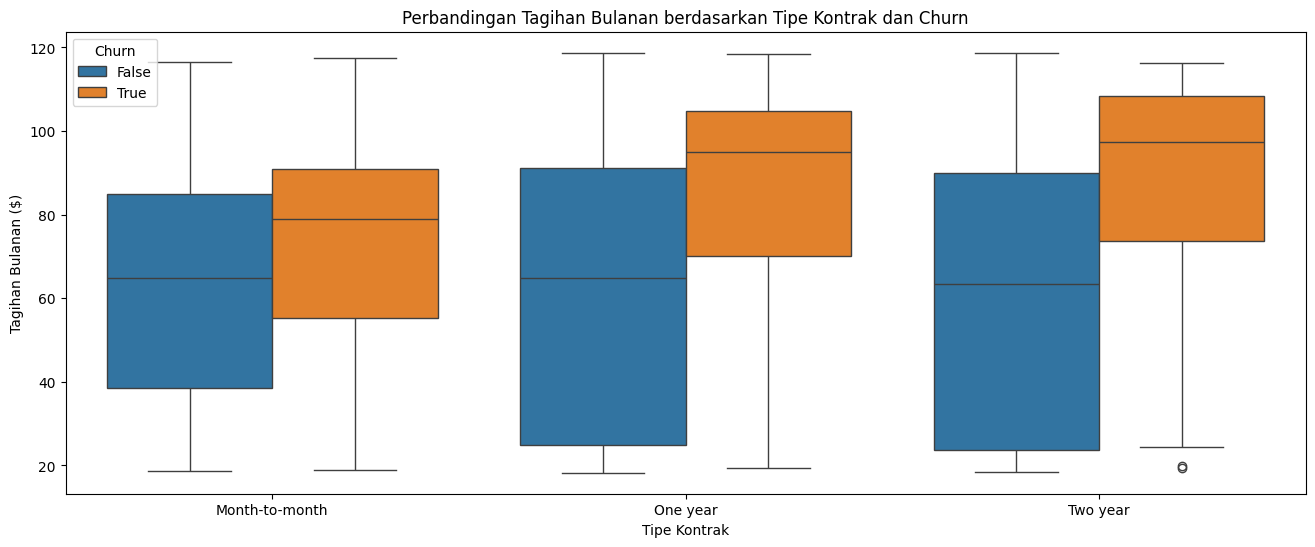

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
sns.boxplot(x='Contract', y='MonthlyCharges', hue='Churn', data=con.table('churn_clean').df())
plt.title('Perbandingan Tagihan Bulanan berdasarkan Tipe Kontrak dan Churn')
plt.xlabel('Tipe Kontrak')
plt.ylabel('Tagihan Bulanan ($)')
plt.show()


**Interpretasi Temuan**
1. High-Risk Segment: Pelanggan dengan kontrak Month-to-month memiliki risiko atrisi tertinggi (42.71%), jauh melampaui kontrak satu tahun (11%) atau dua tahun (2%).
2. Price Sensitivity: (Cek hasil boxplot) Biasanya akan terlihat bahwa pelanggan yang churn pada kontrak bulanan memiliki Monthly Charges yang lebih tinggi daripada yang bertahan.
3. Hipotesis Bisnis: Pelanggan "bulanan" tidak memiliki switching cost (biaya perpindahan) yang tinggi. Begitu tagihan mereka terasa mahal atau ada tawaran kompetitor, mereka langsung berhenti.

----

**analisis Apakah `Tech Support` membantu menahan pelanggan?**

In [27]:
tech_support_analysis = con.sql("""
    SELECT 
        TechSupport, 
        COUNT(*) as Total,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) as Churn_Count,
        ROUND(SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as Churn_Rate
    FROM churn_clean
    GROUP BY TechSupport
""").df()

display(tech_support_analysis)


,TechSupport,Total,Churn_Count,Churn_Rate
0,No,3473,1446.0,41.64
1,Yes,2044,310.0,15.17
2,No internet service,1526,113.0,7.40


**tech Support sangat berpengaruh untuk membantu menaham pelanggan**

---

**Ringkasan Temuan (Executive Summary)**
1. Status Krisis: Churn rate keseluruhan berada di angka yang signifikan (~26%).
2. Titik Lemah Utama: Pelanggan dengan kontrak Month-to-month adalah penyumbang churn terbesar (42.71%).
3. Indikator Layanan: Kurangnya layanan tambahan seperti Tech Support terbukti berkorelasi kuat dengan keputusan pelanggan untuk berhenti.

---


**Rekomendasi Bisnis (Actionable Insights)**

- Insentif Migrasi Kontrak: Memberikan promo atau potongan harga bagi pelanggan month-to-month agar bersedia pindah ke kontrak 1 atau 2 tahun.
- Bundling Layanan: Memberikan layanan Tech Support gratis selama 3 bulan pertama untuk pelanggan baru guna meningkatkan "stickiness" (keterikatan).
- Intervensi Harga: Melakukan evaluasi terhadap pelanggan dengan tagihan di atas rata-rata pada segmen kontrak bulanan, karena mereka adalah kelompok paling berisiko.

---

**Apa Selanjutnya?**
- Akar Masalah: Masalah utama ada pada kontrak Month-to-month dengan tingkat churn 42.71%.
- Data Terolah: kita sudah punya tabel churn_clean di DuckDB yang sudah dibersihkan (kolom TotalCharges sudah menjadi numerik).
- Langkah Lanjut: kita bisa langsung masuk ke tahap Analisis Korelasi atau mulai membangun Model Prediksi (Machine Learning) untuk mengidentifikasi pelanggan yang berisiko sebelum mereka benar-benar pergi.